# Value of Water Hedonic Regression Notebook

To build our hedonic regression model for the economic value of water inherent in the value of agricultural land we focused on Fresno County, CA as our sample area given its large amount of agricultural land parcels and the availability of relevant data. 

In order to hypothesize a measurable valuation of water we considered two variables related to water and land that we could measure: water sources and water uses

In our model we operate under the assumptions that where water comes from and how it is distributed effects the value it has to land (e.g. distance it travels to land and whether or not the land is irrigated) in addition to how much is used and how water is used on the land (e.g. water used for cultivating crops can be related to the revenue from the sales of those crops)

Our water source data includes:
- Water rights data, which we use to measure the distance from water sources to each agricultural land parcel

Our water uses data is compiled from:
- Crop overlay and water use data, which allows us to approximate a total minimum water use on each agricultural land parcel, productivity in revenue by acre foot of water used (based on crop water usage, yield, and sales revenue per agricultural land parcel)

We then considered the control variables necessary to help isolate simulated value in the model. This includes soil quality and land parcel data which contains improvements to land, land size, land use classification for agricultral land parcels, and soil quality.  

We built our dataset around the land parcel data because it allowed us to compile our feature set by land parcel which was a requirement for the web tool we built for leveraging our regression model results. 



In [1988]:
import numpy as np
from scipy import interpolate
from regressors import stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from requests import get
import json
from collections import Counter
import re
import os
from dateutil.parser import parse
import operator
from uuid import uuid4
import sys
import geopandas
import shapefile
import probscale
import seaborn as sns

#from regressors import stats

In [1202]:
from scipy.special import comb 
from sklearn import metrics,linear_model
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from scipy.stats import shapiro
from sklearn.model_selection import GridSearchCV

In [1203]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Dataset Aggregation

The data we are using in our dataset has been compiled from:
- Landgrid: https://landgrid.com/
- California Evapotranspiration Data: http://www.itrc.org/etdata/index.html
- California Agricultural Production and Irrigated Water Use: https://fas.org/sgp/crs/misc/R44093.pdf
- eWRIMS – Electronic Water Rights Information Management System: https://www.waterboards.ca.gov/waterrights/water_issues/programs/ewrims/
- USDA Web Soil Survey https://websoilsurvey.nrcs.usda.gov/



In [1410]:
#load in data
landdata_location = 'data/joined_combined_filtered_mined_soil_water_df_td_17_4.csv'

cropdata_location = 'data/cacropyielddata2.csv'

### Land Parcel Data

The land dataset we are using here is a compilation of Landgrids us parcel data for fresno county, crop yeild data, crop overlay data, and web scraped parcel data

First we need to examine the variables in our land data and remove and select our land features of potential interest. 

In [1411]:
ld = pd.read_csv(landdata_location)

ld.describe()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0_x,geoid,sourceagent,improvval,landval,parval,mail_addstr,...,castorieindex,CropETo,WaterApplied,NetWaterUse_Applied,Factor,AppliedFromETo,AppliedWater,TotalWater,water_dist,city_dist
count,25342.000000,25342.000000,25342.000000,25342.000000,25342.0,0.0,2.270600e+04,2.270600e+04,2.270600e+04,0.0,...,23583.000000,23081.000000,8521.000000,17720.000000,18408.000000,23081.000000,25342.000000,25342.000000,25342.000000,25342.000000
mean,12670.500000,12670.500000,12670.500000,12653.044866,6019.0,NaN,2.044906e+05,1.821032e+05,3.971233e+05,NaN,...,67.803248,2.721640,2.691810,2.642999,0.715431,2.821391,2.732964,3.799631,11.359627,33.113603
std,7315.749597,7315.749597,7315.749597,7297.576590,0.0,NaN,5.281402e+05,2.789549e+05,8.606946e+05,NaN,...,27.120829,0.571238,0.534447,0.953045,0.110369,0.816054,0.779756,0.779756,6.090116,20.524672
min,0.000000,0.000000,0.000000,0.000000,6019.0,NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN,...,1.000000,1.568333,0.600000,1.372093,0.428173,1.173810,0.600000,1.666667,0.125373,4.834046
25%,6335.250000,6335.250000,6335.250000,6334.250000,6019.0,NaN,2.019400e+04,4.766700e+04,1.079668e+05,NaN,...,46.000000,2.303333,2.500000,1.860000,0.676627,2.223810,1.860000,2.926667,6.115502,17.734432
50%,12670.500000,12670.500000,12670.500000,12663.500000,6019.0,NaN,9.008800e+04,1.027580e+05,2.265005e+05,NaN,...,76.000000,2.876667,2.700000,2.367052,0.708955,3.042857,2.700000,3.766667,11.903961,27.117913
75%,19005.750000,19005.750000,19005.750000,18967.750000,6019.0,NaN,2.005930e+05,2.047005e+05,4.151655e+05,NaN,...,90.000000,3.257500,2.900000,3.537037,0.786568,3.586905,3.537037,4.603704,15.470906,41.102918
max,25341.000000,25341.000000,25341.000000,25285.000000,6019.0,NaN,1.990775e+07,9.230949e+06,5.226432e+07,NaN,...,100.000000,3.771667,4.500000,5.044273,1.229223,4.321429,4.530405,5.597072,34.048164,90.957146


In [1412]:
print('Number of colums:', len(ld.columns.tolist()))
print(', '.join(ld.columns.tolist()))

Number of colums: 107
Unnamed: 0, Unnamed: 0.1, Unnamed: 0.1.1, Unnamed: 0_x, geoid, sourceagent, parcelnumb, usecode, improvval, landval, parval, owner, owner2, mailadd, mail_addstr, mail_city, mail_state2, mail_zip, address, saddno, saddpref, saddstr, saddsttyp, sunit, scity, original_address, city, county, state2, szip, address_source, legaldesc, path, ll_uuid, ll_updated_at, homeowner_exemp, lot_area, pers_prop_val, tax_area_code, contract_number, contract_year, non_renewal_year, use_high_best, use_secondary, qoz, qoz_tract, ll_gisacre, lng, lat, gdfindex, Acres_x, Crop2016_x, DWR_revise, Symb_class, MULTIUSE, CLASS1, SPECOND1, PCNT1, CLASS2, SUBCLASS2, SPECOND2, IRR_TYP2PA, UCF_ATT, CROPTYP1, CROPTYP2, Region, Acres, County, Crop2016, GlobalID, Shape_Leng, Shape_Area, land, imps, pp, mhome, tot, pnumb, firstfloor, secondfloor, addsize, tra, loc, bclass, year, gize, pool, psize, Unnamed: 0_y, intersect_area_acre, MUSYM, farmlndcl, irrcapcl, irrcapscl, nirrcapcl, nirrcalscl, castori

We have 101 potential features in our land dataset<sup>1</sup>, however there are 16 columns related to the mailing address which are not valuable to our regression analysis. We also don't need the legal description(legaldesc) for example. 


<a href= "https://docs.google.com/spreadsheets/d/14RcBKyiEGa7q-SR0rFnDHVcovb9uegPJ3sfb3WlNPc0/edit#gid=1010834424"> Data dictionary for landgrid data </a> (citation)

The features of relevance to our analysis include:
- parcel number (for merging our california crop yeild data and water rights
- acreage (parcel size)
- crop (mapped to the parcel using arcgis and crop overlay data for Fresno County) 
- the value of buildings and personal property on the parcel (firstfloor, secondfloor, addsize, gize)
- whether or not the parcel has a pool (as a proxy for purely residential land use),  

With respect to creating methods for measuring water access we are interested in:
- if the land is or isn't irrigated
- the type of irrigation 
- water applied
- net water use
- volume of water available
- distance from water source

In [1413]:
#select features of interest
land_data = ld[['parcelnumb', 'szip', 'county', 'landval', 'parval', 'city_dist', #parcel identifiers
                'll_gisacre', #parcel size in acres
                'Crop2016', #parcel crop
                'firstfloor', 'secondfloor', 'gize', 'mhome', 'pool', 'addsize', 'pers_prop_val', #building information for parcel
                'farmlndcl', 'irrcapcl', 'nirrcapcl',  'nirrcalscl', 'castorieindex', #parcel irrigation data
                'TotalWater', 'water_dist']] #total applied water in acre feet of water based on crop

#remove all na values s

In [1414]:
print(len(land_data))
land_data.head()

25342


,parcelnumb,szip,county,landval,parval,city_dist,ll_gisacre,Crop2016,firstfloor,secondfloor,...,pool,addsize,pers_prop_val,farmlndcl,irrcapcl,nirrcapcl,nirrcalscl,castorieindex,TotalWater,water_dist
0,37002003,93654-9320,fresno,207423.0,294187.0,34.860588,16.97049,Grapes,0.0,0.0,...,False,0.0,0.0,Prime farmland if irrigated,2.0,4.0,s,95.0,2.926667,11.698670
1,36309061,93654-9635,fresno,47692.0,72821.0,32.697260,8.68291,Miscellaneous Deciduous,1148.0,0.0,...,False,0.0,0.0,Farmland of statewide importance,3.0,4.0,s,45.0,4.360258,8.498322
2,05326007T,93656,fresno,NaN,NaN,36.116735,11.46775,Almonds,NaN,NaN,...,False,NaN,NaN,Prime farmland if irrigated and drained,2.0,4.0,s,86.0,4.603704,7.014496
3,30932018,93657-9406,fresno,97978.0,162075.0,18.230165,20.13240,Miscellaneous Truck Crops,0.0,0.0,...,False,0.0,0.0,Prime farmland if irrigated,3.0,4.0,e,72.0,3.223960,1.441799
4,00124003,93620-9451,fresno,16825.0,153086.0,71.870104,6.81335,Cotton,1920.0,0.0,...,False,0.0,0.0,NaN,NaN,NaN,NaN,NaN,4.061667,9.344364


For the purposes of our analysis we decided to drop the na values for all records in our dataset instead of imputing them in some columns and dropping others. Given the methods of aggregation that went into our source data -- for much of the land data, based on county assessors in Fresno and for our crop data, based on crop map overlays -- imputing missing information could misrepresent the variability in our model.

In [1415]:
land_data.dropna(inplace=True)

print(len(land_data))

20638


After removing nan values we lost 4704 records, about 18% of the land dataset. We then turned our attention to folding in our crop yield data 

### Crop Yield Data

In [1710]:
#first load in crop yield data
crop_yield = pd.read_csv(cropdata_location)

In [1711]:
print(', '.join(crop_yield.columns.tolist()))

Commodity, Planted All Purpose Acres, Harvested Acres, Yield, yield_units, Production, Price per Unit, unit_volume, Value of Production in Dollars, Crop Unit Vale ($/acre, Unnamed: 10


From the crop yield data, we took the unit price of a crop per acre ('Crop Unit Vale ($/acre') for calculating parcel specific crop production values in dollars and a water productivity measurement (see below).

In order to do that we matched our land data crops to the crops in the California crop yield dataset.<sup>1</sup>

____
<sup>1</sup> Citation needed

In [1712]:
#crop yield crops
ca_crops = set(crop_yield['Commodity'].tolist())
               
print('CA crop yield crops:\n\t', ', '.join(sorted(ca_crops)))

CA crop yield crops:
	 ALFALFA, ALMONDS, APPLES, APRICOTS, ARTICHOKES, ARTICHOKES, FRESH MARKET, ARTICHOKES, UTILIZED, ASPARAGUS, ASPARAGUS, FRESH MARKET, ASPARAGUS, UTILIZED, AVACADOS, BARLEY, BEANS, SNAP, BEANS, SNAP, FRESH MARKET, BEANS, SNAP, PROCESSING, BEANS, SNAP, UTILIZED, BROCCOLI, BROCCOLI, FRESH MARKET, BROCCOLI, PROCESSING, BROCCOLI, UTILIZED, CABBAGE, CABBAGE, FRESH MARKET, CABBAGE, PROCESSING, CABBAGE, UTILIZED, CARROTS, CARROTS, FRESH MARKET, CARROTS, PROCESSING, CARROTS, UTILIZED, CAULIFLOWER, CAULIFLOWER, FRESH MARKET, CAULIFLOWER, PROCESSING, CAULIFLOWER, UTILIZED, CELERY, CELERY, FRESH MARKET, CELERY, PROCESSING, CELERY, UTILIZED, CHERRIES, SWEET, CHICKPEAS, CORN, CORN, GRAIN, CORN, SILAGE, COTTON, COTTON, COTTONSEED, COTTON, PIMA, COTTON, UPLAND, CUCUMBERS, CUCUMBERS, FRESH MARKET, CUCUMBERS, PROCESSING, CUCUMBERS, UTILIZED, GARLIC, GARLIC, FRESH MARKET, GARLIC, PROCESSING, GARLIC, UTILIZED, GRAPEFRUIT, GRAPEFRUIT, FRESH MARKET, GRAPEFRUIT, PROCESSING, GRAPEFRUIT, U

In [1713]:
#land data crop list
land_data['Crop2016'] = land_data['Crop2016'].str.upper()
land_crops = set(land_data['Crop2016'].tolist())
print('Land Dataset crops:\n\t', ', '.join(sorted(land_crops)))

Land Dataset crops:
	 ALFALFA, ALMONDS, APPLES, BEANS, SNAP, BUSH BERRIES, CARROTS, CHERRIES, SWEET, CITRUS, COLE CROPS, CORN, GRAIN, COTTON, COTTONSEED, DATES, FLOWERS, NURSERY AND CHRISTMAS TREE FARMS, GARLIC, GRAPES, GREENHOUSE, HAY, (EXCL ALFALFA), KIWIS, LETTUCE, HEAD, MELONS, SQUASH AND CUCUMBERS, MISCELLANEOUS DECIDUOUS, MISCELLANEOUS GRASSES, MISCELLANEOUS SUBTROPICAL FRUITS, MISCELLANEOUS TRUCK CROPS, MIXED PASTURE, OLIVES, PEACHES, PEARS, PEPPERS, PISTACHIOS, POMEGRANATES, PRUNES, RICE, SAFFLOWER, STRAWBERRIES, SUNFLOWER, TOMATOES, IN THE OPEN, WALNUTS, WHEAT, YOUNG PERENNIALS


In [1714]:
overlap = land_crops.intersection(ca_crops)
print('Overlap:', ', '.join(overlap))

Overlap: ALMONDS, CORN, GRAIN, APPLES, TOMATOES, IN THE OPEN, SAFFLOWER, GRAPES, CARROTS, PRUNES, WHEAT, BEANS, SNAP, COTTON, COTTONSEED, HAY, (EXCL ALFALFA), GARLIC, CHERRIES, SWEET, RICE, ALFALFA, LETTUCE, HEAD, PEACHES, SUNFLOWER, PEARS


While there is a good amount of overlap the California crop yield dataset had more crops, some extra text that preveneted a match, and some groupings that intersected a single crop in our land data so we had to make some decisions about which to include.  

In [1715]:
land_remaining = land_crops - overlap

ca_remaining = ca_crops - overlap

print('Crops not matched in land dataset:\n', ', '.join(sorted(list(land_remaining))), '\n')

print('Crops left in the california crop dataset:\n', ', '.join(sorted(list(ca_remaining))))


Crops not matched in land dataset:
 BUSH BERRIES, CITRUS, COLE CROPS, DATES, FLOWERS, NURSERY AND CHRISTMAS TREE FARMS, GREENHOUSE, KIWIS, MELONS, SQUASH AND CUCUMBERS, MISCELLANEOUS DECIDUOUS, MISCELLANEOUS GRASSES, MISCELLANEOUS SUBTROPICAL FRUITS, MISCELLANEOUS TRUCK CROPS, MIXED PASTURE, OLIVES, PEPPERS, PISTACHIOS, POMEGRANATES, STRAWBERRIES, WALNUTS, YOUNG PERENNIALS 

Crops left in the california crop dataset:
 APRICOTS, ARTICHOKES, ARTICHOKES, FRESH MARKET, ARTICHOKES, UTILIZED, ASPARAGUS, ASPARAGUS, FRESH MARKET, ASPARAGUS, UTILIZED, AVACADOS, BARLEY, BEANS, SNAP, FRESH MARKET, BEANS, SNAP, PROCESSING, BEANS, SNAP, UTILIZED, BROCCOLI, BROCCOLI, FRESH MARKET, BROCCOLI, PROCESSING, BROCCOLI, UTILIZED, CABBAGE, CABBAGE, FRESH MARKET, CABBAGE, PROCESSING, CABBAGE, UTILIZED, CARROTS, FRESH MARKET, CARROTS, PROCESSING, CARROTS, UTILIZED, CAULIFLOWER, CAULIFLOWER, FRESH MARKET, CAULIFLOWER, PROCESSING, CAULIFLOWER, UTILIZED, CELERY, CELERY, FRESH MARKET, CELERY, PROCESSING, CELERY, U

We adjusted the labeling for alfalfa, beans, corn, lettuce, 'melons, squash, and cucumber', miscellaneous grain and hay, garlic, peaches, prunes and apricots, potatoes and sweet potatoes, sunflower. Where there were seemingly duplicate crop records, we made sure to select the crop data containing a 'Price per Unit' value.

In [1716]:
land_data = land_data.replace({'ALFALFA AND ALFALFA MIXTURES':'ALFALFA', 'BEANS (DRY)': 'BEANS, SNAP', 
            'CORN, SORGHUM AND SUDAN':'CORN, GRAIN', 'LETTUCE/LEAFY GREENS':'LETTUCE, HEAD', 
            'MISCELLANEOUS GRAIN AND HAY': 'HAY, (EXCL ALFALFA)', 'ONIONS AND GARLIC': 'GARLIC', 
            'PEACHES/NECTARINES': 'PEACHES', 'PLUMS, PRUNES AND APRICOTS': 'PRUNES', 
            'POTATOES AND SWEET POTATOES': 'POTATOES', 'SUNFLOWERS': 'SUNFLOWER', 'TOMATOES': 'TOMATOES, IN THE OPEN', 
            'COTTON': 'COTTON, COTTONSEED', 'CHERRIES':'CHERRIES, SWEET', 'SQUASH AND CUCUMBERS': 'SQUASH', })



We then looked at the overlap again and dropped the rows that dont overlap

In [1717]:
newland_crops = set(land_data['Crop2016'].tolist())

overlap = newland_crops.intersection(ca_crops)
print('Matched:', overlap)

Matched: {'ALMONDS', 'CORN, GRAIN', 'APPLES', 'TOMATOES, IN THE OPEN', 'SAFFLOWER', 'GRAPES', 'CARROTS', 'PRUNES', 'WHEAT', 'BEANS, SNAP', 'COTTON, COTTONSEED', 'HAY, (EXCL ALFALFA)', 'GARLIC', 'CHERRIES, SWEET', 'RICE', 'ALFALFA', 'LETTUCE, HEAD', 'PEACHES', 'SUNFLOWER', 'PEARS'}


In [1718]:
incrop = list(overlap)

available_crops = land_data['Crop2016'].isin(incrop)

land_matched = land_data[available_crops]

In [1719]:
len(land_matched)

14429

With the available crop data we were able to match 14,429 records to our California crop yield data. 

In [1720]:
#get matched crops in ca crop yield

available_commodity = crop_yield['Commodity'].isin(incrop)

ca_crops = crop_yield[available_commodity]



In [1721]:
#rename columns to merge

ca_crops.rename(columns = {'Commodity': 'FinalCrop'}, inplace=True)
merge_crops = ca_crops[['FinalCrop', 'Crop Unit Vale ($/acre', 'Yield', 'yield_units']]

land_matched.rename(columns = {'Crop2016': 'FinalCrop'}, inplace=True)




In [1722]:
#now merge

full_set = land_matched.merge(merge_crops, on='FinalCrop')

Checking to see if values were merged in 


In [1723]:
print(full_set.iloc[0]['FinalCrop'])
print(full_set.iloc[0]['Crop Unit Vale ($/acre'])


GRAPES
600.0


In [1724]:
set(full_set['FinalCrop'].tolist())

{'ALFALFA',
 'ALMONDS',
 'APPLES',
 'BEANS, SNAP',
 'CARROTS',
 'CHERRIES, SWEET',
 'CORN, GRAIN',
 'COTTON, COTTONSEED',
 'GARLIC',
 'GRAPES',
 'HAY, (EXCL ALFALFA)',
 'LETTUCE, HEAD',
 'PEACHES',
 'PEARS',
 'PRUNES',
 'RICE',
 'SAFFLOWER',
 'SUNFLOWER',
 'TOMATOES, IN THE OPEN',
 'WHEAT'}

## EDA

After compiling our dataset we took a look at our variables of interest, which include our potential target variables ('landval' or 'parval'), land related variables ('ll_gisacre', 'city_dist') water related variables (water_dist, TotalWater), building indicators('firstfloor', 'secondfloor', 'gize', mhome), crop('FinalCrop', 'Crop Unit Vale ($/acre), and soil indicators('farmlndcl', 'irrcapcl', 'nirrcapcl', 'nirrcalscl', 'castorieindex')

In [1725]:
full_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14429 entries, 0 to 14428
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   parcelnumb              14429 non-null  object 
 1   szip                    14429 non-null  object 
 2   county                  14429 non-null  object 
 3   landval                 14429 non-null  float64
 4   parval                  14429 non-null  float64
 5   city_dist               14429 non-null  float64
 6   ll_gisacre              14429 non-null  float64
 7   FinalCrop               14429 non-null  object 
 8   firstfloor              14429 non-null  float64
 9   secondfloor             14429 non-null  float64
 10  gize                    14429 non-null  float64
 11  mhome                   14429 non-null  float64
 12  pool                    14429 non-null  bool   
 13  addsize                 14429 non-null  float64
 14  pers_prop_val           14429 non-null

#### Land Values

- landval: is the land value - in US Dollars

We wanted to examine our target variable, land value, for its distribution and outliers. Given that we began with all land parcels in Fresno County— both residential and agricultural— it was important to identify outliers early on and narrow our scope as best we could to those used for commercial agriculture.

The reason we looked to filter for agricultural land based on land value is because unfortunately the usecode data that came with each land parcel had a schema that was undeciferable despite contact with the Fresno County Assessors Office. 



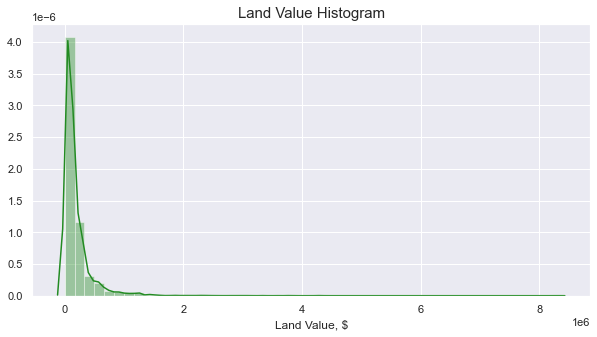

In [1892]:
fig, ax = plt.subplots(figsize=(10,5))


sns.distplot(full_set.landval, bins=50, kde=True, ax=ax, color='forestgreen')
plt.title('Land Value Histogram', fontsize=15)
plt.xlabel('Land Value, $', fontsize=12);

Our land values had a positively skewed distribution with a very long tail meaning there were some very big outliers. 

Given the skew we also wanted to work with a more normal distribution so we took the natural log of our landval column



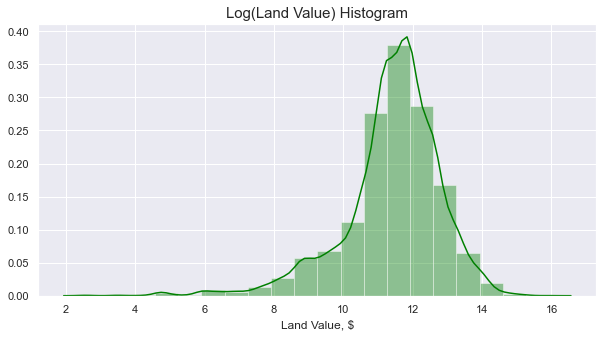

In [1906]:
full_set['landval_log'] = np.log(full_set['landval'])

fig, ax = plt.subplots(figsize=(10,5))


sns.distplot(full_set[np.isfinite(full_set.landval_log)]['landval_log'], bins=20, kde=True, ax=ax, color='green')
plt.title('Log(Land Value) Histogram', fontsize=15)
plt.xlabel('Land Value, $', fontsize=12);

As we can see ther is a more normal distribution after log transforming the land value target. We will use this in our analysis

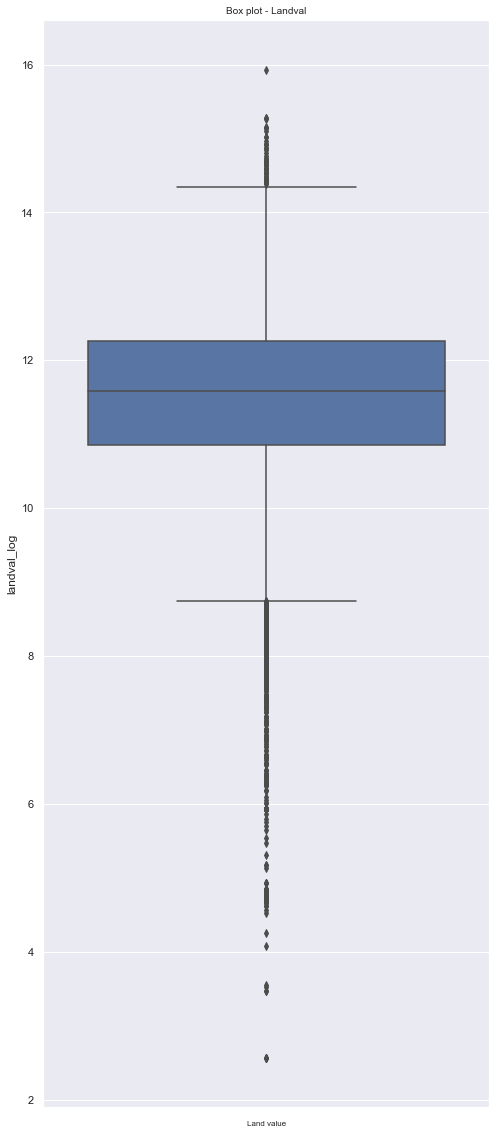

In [1905]:
fig, ax = plt.subplots(1, figsize=(8,20))


sns.boxplot(y=full_set['landval_log'], ax=ax)
ax.set_title('Box plot - {}'.format('Landval'), fontsize=10)
ax.set_xlabel('Land value', fontsize=8)

plt.show()

There was a clearly large spread in terms of the land values in our dataset, which tracks with the fact that it is undifferentiated between purely residential, commercial, or agricultural land.  In order to narrow the scope we later decided to apply an upper and lower band for the land values in our hedonic analysis.

#### Land attributes

- ll_gisacre: parcel acres as calculated by Loveland (landgrid from county parcel geometry
- city dist: parcel distance from nearest city center

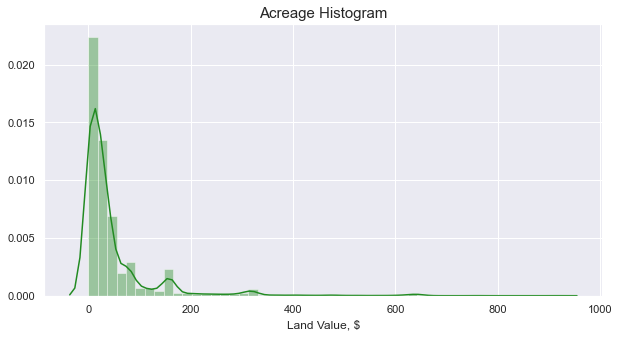

In [1902]:
fig, ax = plt.subplots(figsize=(10,5))


sns.distplot(full_set.ll_gisacre, bins=50, kde=True, ax=ax, color='forestgreen')
plt.title('Acreage Histogram', fontsize=15)
plt.xlabel('Parcel Acreage', fontsize=12);


While we did not end up using acreage explicitly in our regression analysis (see below for reasoning) we did want to note the skew of parcel sizes in the dataset. 

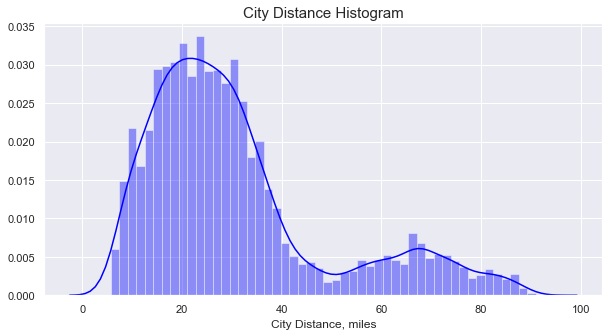

In [1909]:
fig, ax = plt.subplots(figsize=(10,5))


sns.distplot(full_set.city_dist, bins=50, kde=True, ax=ax, color='blue')
plt.title('City Distance Histogram', fontsize=15)
plt.xlabel('City Distance, miles', fontsize=12);

Our city distance feature was calculated using arc gis and parcel ids. It appeared to have a bimodal histogram.

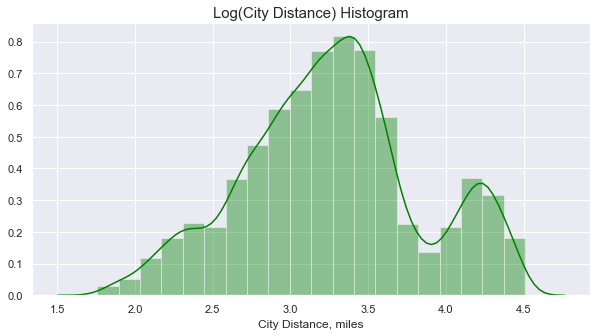

In [1919]:
full_set['city_dist_log'] = np.log(full_set['city_dist'])


fig, ax = plt.subplots(figsize=(10,5))


sns.distplot(full_set[np.isfinite(full_set.city_dist_log)]['city_dist_log'], bins=20, kde=True, ax=ax, color='green')
plt.title('Log(City Distance) Histogram', fontsize=15)
plt.xlabel('City Distance, miles', fontsize=12);

Upon applying a log transformation we did not see a signicficant change in the distribution, with what appeared to be another bimodal distribtibuion with the first peak having a negative skew 

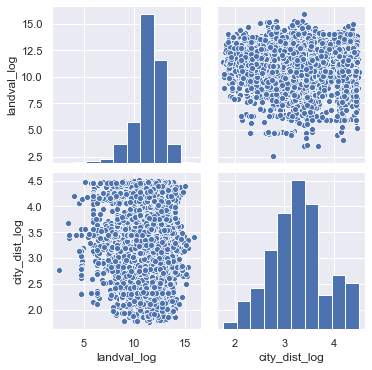

In [1915]:
land_city_bivariate = full_set[['landval_log','city_dist_log']]

sns.pairplot(land_city_bivariate[np.isfinite(land_city_bivariate[['landval_log', 'city_dist_log']])])
                       
          

As we can see the  city distance and land values were weakly negatively correlated, suggesting that parcel distance from the nearest city does have an effect on parcel land valuation. We later used city distance  as an added control to our regression analysis

#### Water variables

- water dist: distance from water source to parcel, calculated using arc gis 
- total water: total water applied in acre feet per crop, adjusted for rainfall


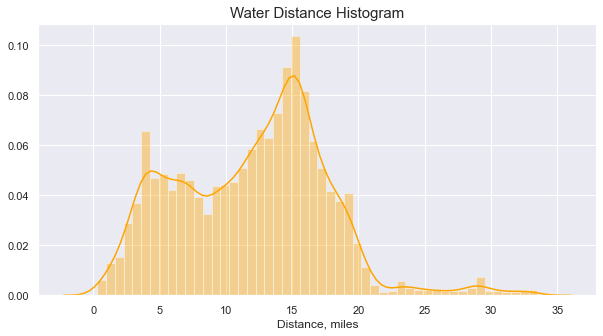

In [1917]:
fig, ax = plt.subplots(figsize=(10,5))


sns.distplot(full_set.water_dist, bins=50, kde=True, ax=ax, color='orange')
plt.title('Water Distance Histogram', fontsize=15)
plt.xlabel('Distance, miles', fontsize=12);


The water distance distribution appeared to be bimodal, which when compared to the city distance distribution, has some merit in that the geographical groupings of our land parcels could account for the dual peaks in both distance metrics.

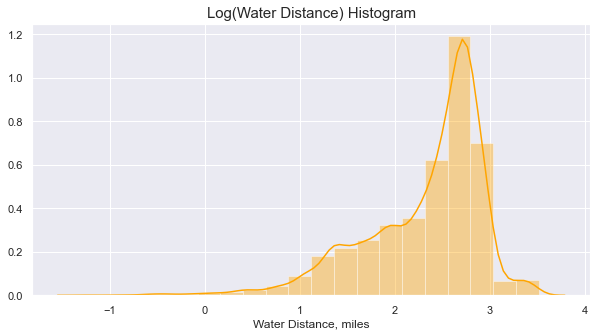

In [1920]:
full_set['water_dist_log'] = np.log(full_set['water_dist'])

fig, ax = plt.subplots(figsize=(10,5))


sns.distplot(full_set[np.isfinite(full_set.water_dist_log)]['water_dist_log'], bins=20, kde=True, ax=ax, color='orange')
plt.title('Log(Water Distance) Histogram', fontsize=15)
plt.xlabel('Water Distance, miles', fontsize=12);



Log transforming our water distance yielded a negative skewed disitribution. 

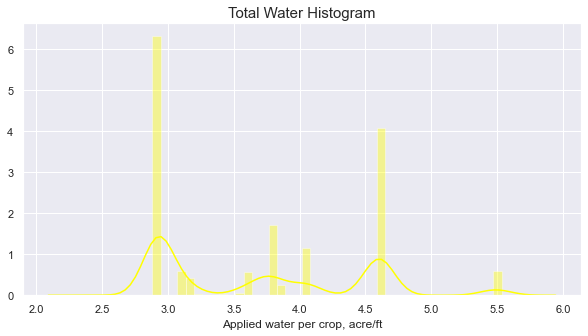

In [1922]:
fig, ax = plt.subplots(figsize=(10,5))


sns.distplot(full_set.TotalWater, bins=50, kde=True, ax=ax, color='yellow')
plt.title('Total Water Histogram', fontsize=15)
plt.xlabel('Applied water per crop, acre/ft', fontsize=12);

The total water variable had a highly irregular distribution we did not worry about because we used Total Water to calculate the minimum available water using parcel acreage. A bivariate analysis of our land value and water distance also yielded a strong negative ecorrelation to land value, suggesting that distance from water source negatively impacts the parcel land value. 

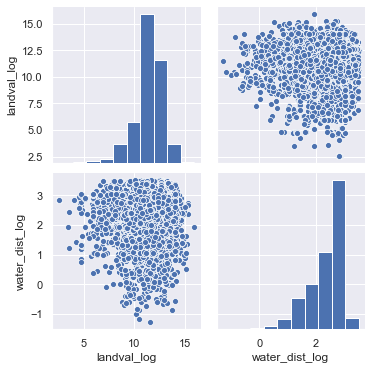

In [1924]:
land_city_bivariate = full_set[['landval_log','water_dist_log']]

sns.pairplot(land_city_bivariate[np.isfinite(land_city_bivariate[['landval_log', 'water_dist_log']])])
                     

#### Building indicators aka improvements to land

- firstfloor: indicates if there is a building on the parcel and the size of the first floor
- second floor: indicates if there is a second floor on the building on the parcel and its size
- gize: indicates the presence of a garage and its size


We ran bivariate analysis on each one of our building indicator variables and discovered week correlations between those and our land value, so we omitted them from our model.


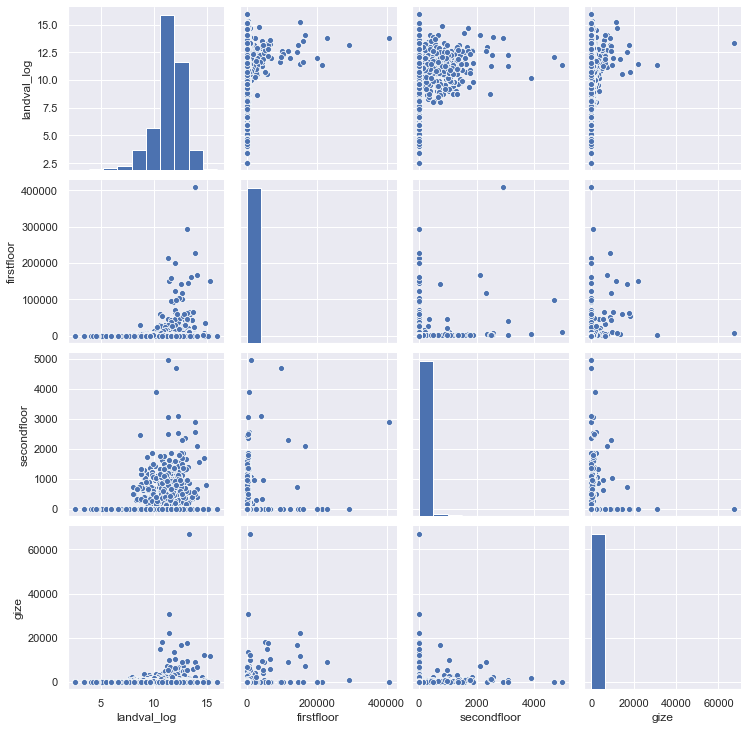

In [1943]:
land_building_bivariate = full_set[['landval_log','firstfloor', 'secondfloor', 'gize']]

sns.pairplot(land_building_bivariate[np.isfinite(land_building_bivariate[['landval_log','firstfloor', 'secondfloor', 'gize']])])
       

#### Soil indicators
- farmlndcl: farmland type (see below)
- irrcapcl: irrigation status 1
- nirrcapcl: irrigation status 2
- nirrcalscl: irrigation status 3 
- castorieindex: soil quality ranking



In [1766]:
#what is in farmland column

print('Farmlndcl values:\n', '\n '.join(set(full_set['farmlndcl'].tolist())))

Farmlndcl values:
 Prime farmland if irrigated and either protected from flooding or not frequently flooded during the growing season
 Not prime farmland
 Prime farmland if irrigated
 Prime farmland if irrigated and reclaimed of excess salts and sodium
 Prime farmland if irrigated and drained
 Farmland of statewide importance


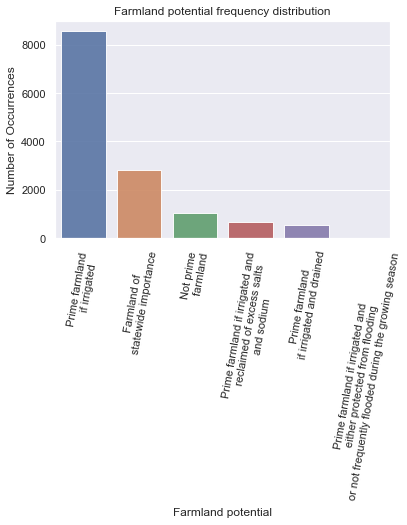

In [1767]:
#frequency distribution for farmland

farmland_count = full_set['farmlndcl'].value_counts()
labels = []
#make the text nicer
for label in farmland_count.index:
    word = label.split(' ')
    if len(word) < 8:
        word.insert(2, '\n')
    else:
        word.insert(5, '\n')
        word.insert(10, '\n')
    labels.append(' '.join(word))
    

        
sns.set(style="darkgrid")
sns.barplot(labels, farmland_count.values, alpha=0.9)
plt.title('Farmland potential frequency distribution')
plt.xlabel('Farmland potential', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=80)
plt.show()

Interestingly prime irrigated farmland had the highest frequency in our dataset

In order to add it to farmland potential to our regression model we encoded the categories numerically.

In [1769]:
full_set['farmlndcl'] = full_set['farmlndcl'].astype('category')
full_set['farmlndcl'] = full_set['farmlndcl'].cat.codes
full_set['farmlndcl'] = full_set['farmlndcl'].astype('float64')


full_set['farmlndcl'].head()

0    2.0
1    2.0
2    2.0
3    2.0
4    2.0
Name: farmlndcl, dtype: float64

All four of our irrigation variables were coded categorically but with numbers so we converted them as we did the other categorical variable. 

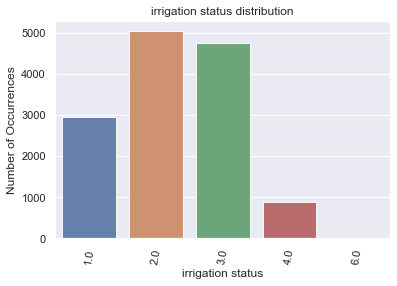

In [1770]:
irrigation_count = full_set['irrcapcl'].value_counts()       
sns.set(style="darkgrid")
sns.barplot(irrigation_count.index, irrigation_count.values, alpha=0.9)
plt.title('irrigation status distribution')
plt.xlabel('irrigation status', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=80)
plt.show()

In [1771]:
full_set['irrcapcl'] = full_set['irrcapcl'].astype('category')
full_set['irrcapcl'] = full_set['irrcapcl'].cat.codes
full_set['irrcapcl'] = full_set['irrcapcl'].astype('float64')

full_set['irrcapcl'].head()

0    1.0
1    0.0
2    1.0
3    2.0
4    2.0
Name: irrcapcl, dtype: float64

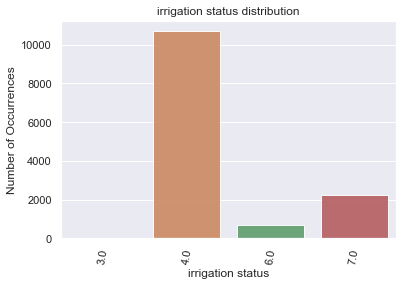

In [1772]:
irrigation_count = full_set['nirrcapcl'].value_counts()       
sns.set(style="darkgrid")
sns.barplot(irrigation_count.index, irrigation_count.values, alpha=0.9)
plt.title('irrigation status distribution')
plt.xlabel('irrigation status', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=80)
plt.show()

In [1773]:
full_set['nirrcapcl'] = full_set['nirrcapcl'].astype('category')
full_set['nirrcapcl'] = full_set['nirrcapcl'].cat.codes
full_set['nirrcapcl'] = full_set['nirrcapcl'].astype('float64')

full_set['nirrcapcl'].head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: nirrcapcl, dtype: float64

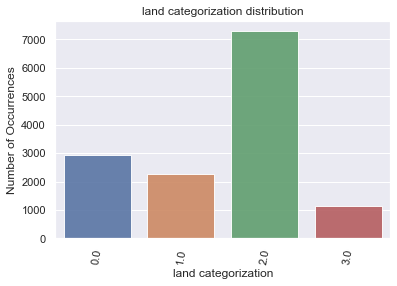

In [1774]:
irrigation_count = full_set['nirrcalscl'].value_counts()       
sns.set(style="darkgrid")
sns.barplot(irrigation_count.index, irrigation_count.values, alpha=0.9)
plt.title('land categorization distribution')
plt.xlabel('land categorization', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=80)
plt.show()

In [1775]:
full_set['nirrcalscl'] = full_set['nirrcalscl'].astype('category')
full_set['nirrcalscl'] = full_set['nirrcalscl'].cat.codes
full_set['nirrcalscl'] = full_set['nirrcalscl'].astype('float64')

full_set['farmlndcl'].head()

0    2.0
1    2.0
2    2.0
3    2.0
4    2.0
Name: farmlndcl, dtype: float64

The Castorie index we left as is becasue it is an ordinal ranking scale for soil that we used to apply acreage to get a crop_soil_quality metric

In [1904]:
print(set(full_set['castorieindex'].tolist()))

{3.0, 4.0, 5.0, 7.0, 10.0, 11.0, 12.0, 14.0, 15.0, 16.0, 18.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 75.0, 76.0, 77.0, 80.0, 81.0, 85.0, 86.0, 88.0, 90.0, 95.0, 100.0}


## Feature Engineering

Based on our hypothesized value of water variables we thought the 'minimimum available water per parcel' would be helpful in our analysis in addition to the 'minimum water revenue per parcel'.


We also wanted to explore whether or not 'water productivity'- the economic value produced per acre-foot of water applied to the parcel crop, as measured in dollars per acre-foot - would be a good proxy for waters value as it relates to land value. 

We also wanted to see if controlling for the total monetary value of crops producable per parcel would be helpful in the model. 




Now we add two columns to our dataset to hold our applied water in millions of acre feet and our water productivity column and fill in both

In [1732]:
full_set['crop_rev'] = None
full_set['water_productivity'] = None
full_set['min_avail_water'] = None
full_set['min_water_rev'] = None

The 'crop_rev' feature is the total monetary value of crops per parcel using crop unit value * parcel acres where crop unit value is derived from the per crop CA total production in revenue divided by total harvested acres in the california crop yield dataset. 

We recognize this method is a bit crude given that not all acres on a given parcel are used entirely for cultivating crops. For the purposes of this exploration we created the measurement to look at its potential benefit in our analysis. 

In [1733]:
full_set['Crop Unit Vale ($/acre'] = full_set['Crop Unit Vale ($/acre'].astype('float64')



for i, r in full_set.iterrows():
    full_set.at[i,'crop_rev'] = r['Crop Unit Vale ($/acre'] * r['ll_gisacre']
    
full_set['crop_rev'] = full_set['crop_rev'].astype('float64')
    

The 'water_productivity' feature is the parcel crop revenue value per acre divided by the total water per acre of applied water to the crop. 

In [1734]:

for i, r in full_set.iterrows():


    #divide millions by millions to get a revenue per acre feet of water applied
    converted = r['TotalWater'] * 1000000

    full_set.at[i, 'water_productivity'] = float(r['crop_rev'])/converted

  
full_set['water_productivity'] = full_set['water_productivity'].astype('float64')

In [1735]:
full_set['water_productivity'].head()

0    0.003479
1    0.007366
2    0.032299
3    0.002757
4    0.007922
Name: water_productivity, dtype: float64

The minimum water available per parcel was derved using the acre feet applied per crop * parcel acreage

In [1736]:
for i, r in full_set.iterrows():

    
    full_set.at[i, 'min_avail_water'] = r['TotalWater'] * r['ll_gisacre'] 

full_set['min_avail_water'] = full_set['min_avail_water'].astype('float64')

In [1737]:
full_set['min_avail_water'].head()

0     49.666967
1    105.151621
2    461.082900
3     39.351989
4    113.096673
Name: min_avail_water, dtype: float64

We then used the water productivity value to get a potential revenue total value from the number of acres. We took our min_avail_water in acre-feet and multiplied that by our water productivity value to get a min water revenue in dollars.

In [1738]:
for i, r in full_set.iterrows():

    full_set.at[i, 'min_water_rev'] = r['min_avail_water'] * r['water_productivity'] 
    

full_set['min_water_rev'] = full_set['min_water_rev'].astype('float64')

In [1739]:
full_set['min_water_rev']

0         0.172799
1         0.774527
2        14.892334
3         0.108477
4         0.895993
           ...    
14424     0.010897
14425     0.699930
14426     0.010314
14427     0.199706
14428     0.012955
Name: min_water_rev, Length: 14429, dtype: float64

Given that we are focusing on agricultural land we decided to remove the parcels which had the presence of a swimming pool, as they denoted a residential use for the parcel

In [1740]:

#exclude pools
full_set.drop(full_set[full_set['pool'] == True].index, inplace=True)

#checking to see if it worked
full_set['pool']

We then took a quick look at our distribution on engineered features. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16e63bac8>,
      dtype=object)

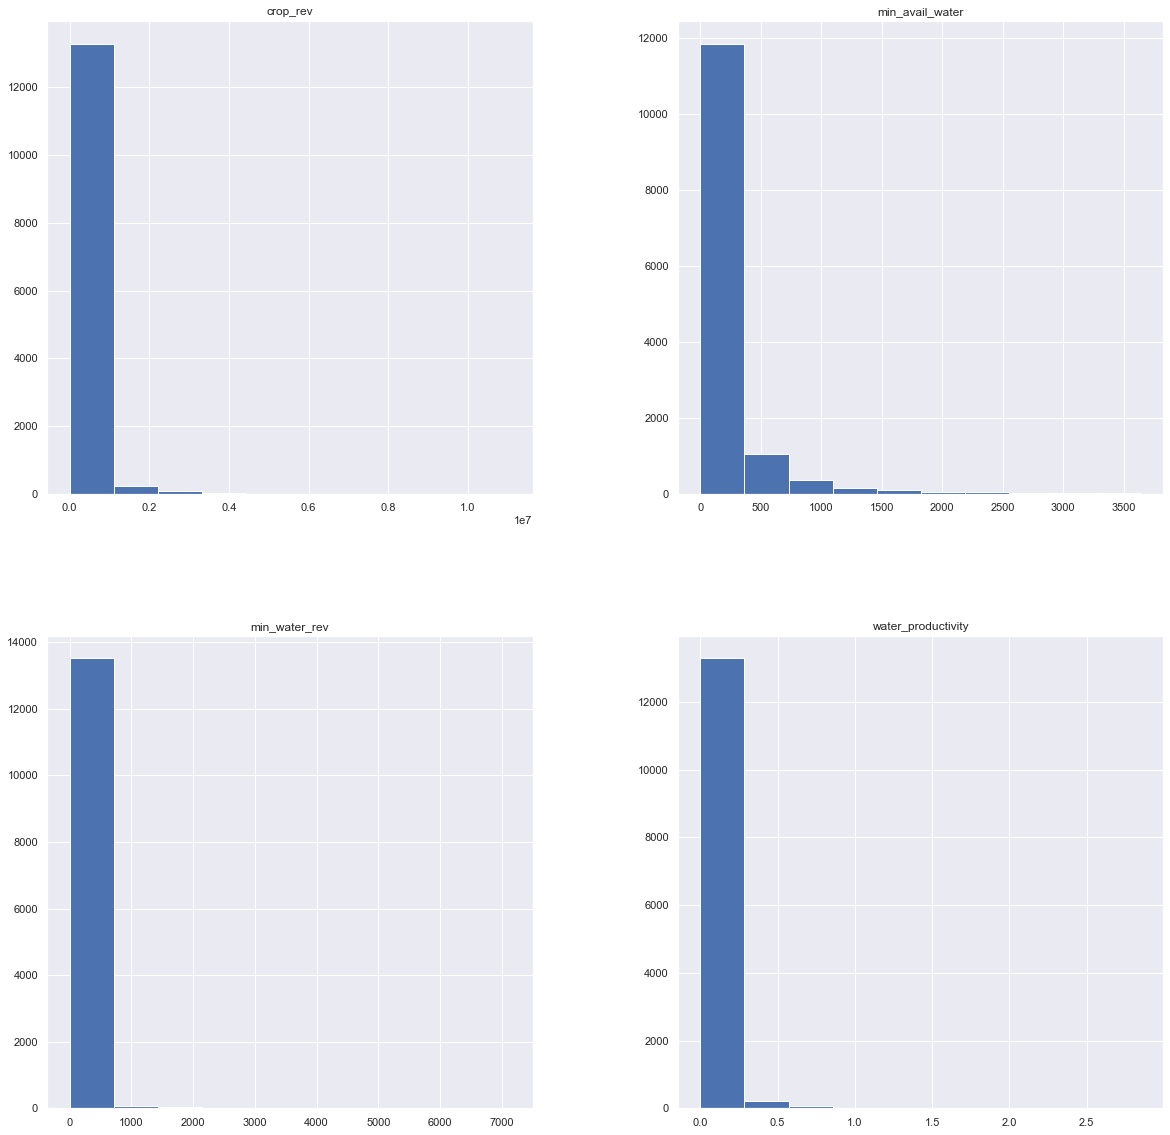

In [1948]:
full_set[['crop_rev', 'water_productivity', 'min_avail_water', 'min_water_rev']].hist(layout=(2, 2), figsize=(20,20))


It was clear they could benefit from log transformations ot acheive more normal distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16ead1048>,
      dtype=object)

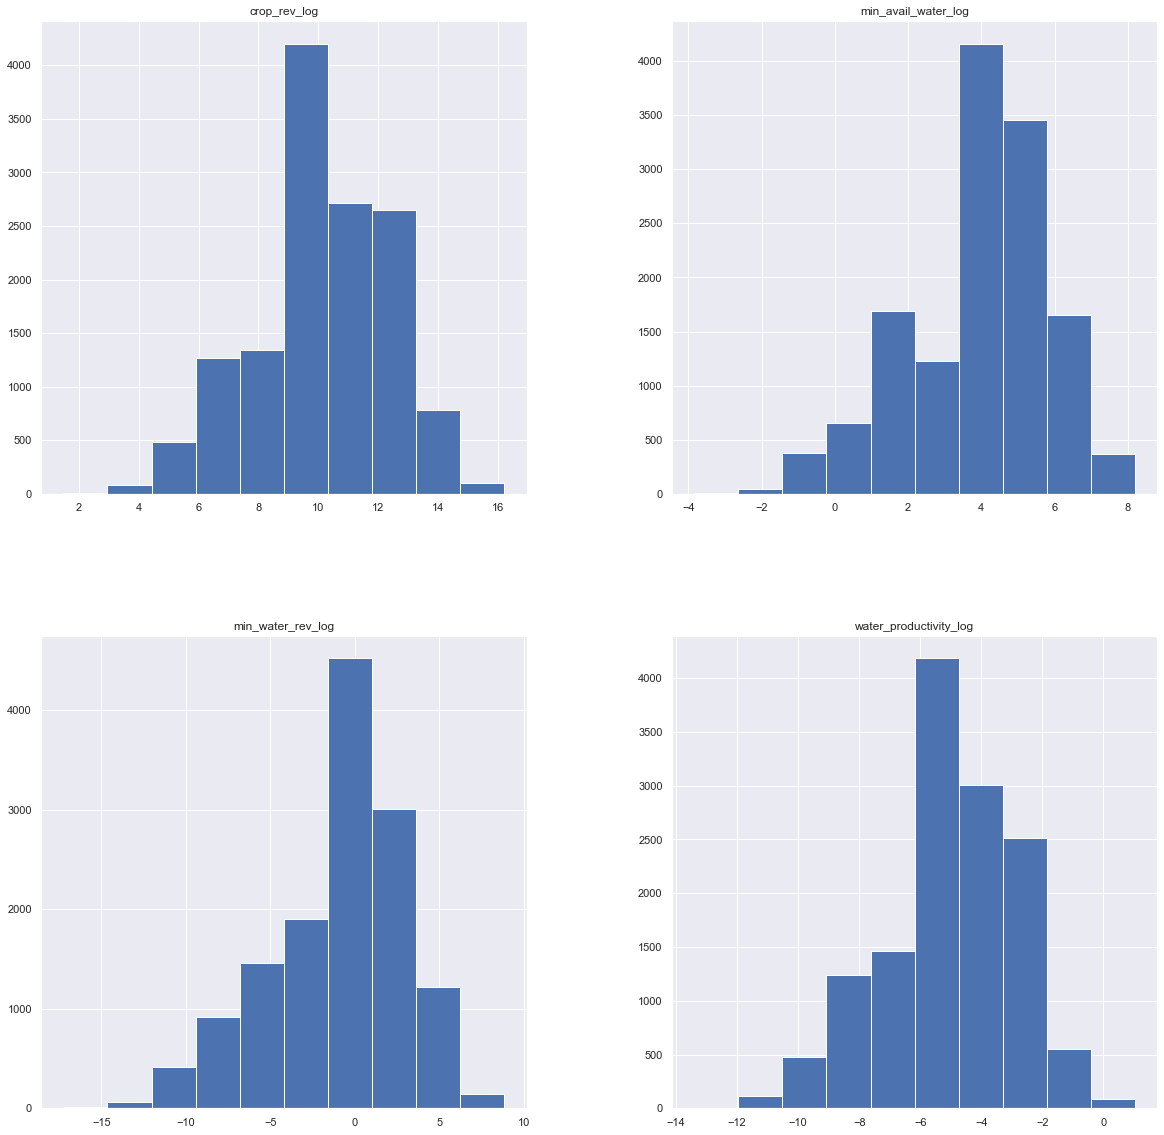

In [1947]:
full_set['min_water_rev_log'] = np.log(full_set['min_water_rev'])
full_set['min_avail_water_log'] = np.log(full_set['min_avail_water'])
full_set['water_productivity_log'] = np.log(full_set['water_productivity'])
full_set['crop_rev_log'] = np.log(full_set['crop_rev'])

full_set[np.isfinite(full_set[['min_avail_water_log', 'water_productivity_log', 'crop_rev_log', 'min_water_rev_log']])][['min_avail_water_log', 'water_productivity_log', 'crop_rev_log', 'min_water_rev_log']].hist(figsize=(20,20), layout=(2,2))


## Hedonic Regression Analysis

Before we built our hedonic regression equation we took another look at the correlation between our variables in sub sections and more broadly. 


              landval  ll_gisacre  firstfloor  secondfloor      gize
landval      1.000000    0.636023    0.055569    -0.004404  0.013369
ll_gisacre   0.636023    1.000000   -0.041015    -0.041044 -0.058248
firstfloor   0.055569   -0.041015    1.000000     0.157698  0.230662
secondfloor -0.004404   -0.041044    0.157698     1.000000  0.083014
gize         0.013369   -0.058248    0.230662     0.083014  1.000000


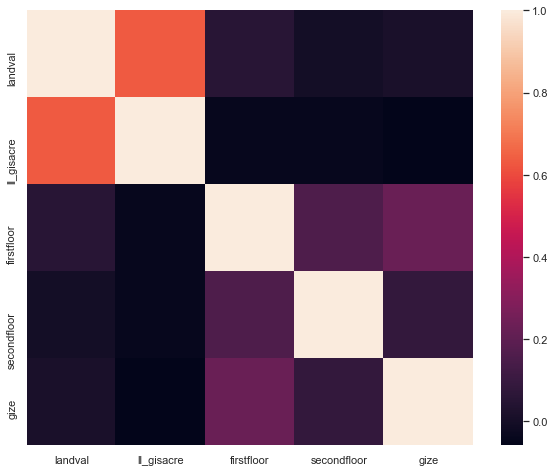

In [1778]:
##check aganst acreage, building on land
print(full_set[['landval', 'll_gisacre', 'firstfloor', 'secondfloor', 'gize']].corr())

f, ax = plt.subplots(figsize=(10, 8))
corr = full_set[['landval', 'll_gisacre', 'firstfloor', 'secondfloor', 'gize']].corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

                     landval  min_avail_water  min_water_rev  TotalWater  \
landval             1.000000         0.620690       0.373358    0.083858   
min_avail_water     0.620690         1.000000       0.589808    0.233726   
min_water_rev       0.373358         0.589808       1.000000    0.073626   
TotalWater          0.083858         0.233726       0.073626    1.000000   
water_productivity  0.402107         0.599377       0.880732    0.138696   

                    water_productivity  
landval                       0.402107  
min_avail_water               0.599377  
min_water_rev                 0.880732  
TotalWater                    0.138696  
water_productivity            1.000000  


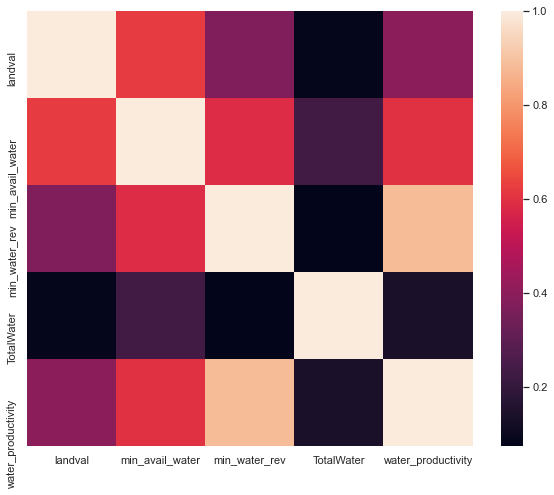

In [1779]:
#water metrics
print(full_set[['landval', 'min_avail_water', 'min_water_rev', 'TotalWater', 'water_productivity']].corr())

f, ax = plt.subplots(figsize=(10, 8))
corr = full_set[['landval', 'min_avail_water', 'min_water_rev', 'TotalWater', 'water_productivity']].corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

             landval  irrcapcl  nirrcapcl  nirrcalscl
landval     1.000000  0.013644   0.109749    0.015911
irrcapcl    0.013644  1.000000  -0.056347    0.587741
nirrcapcl   0.109749 -0.056347   1.000000   -0.014078
nirrcalscl  0.015911  0.587741  -0.014078    1.000000


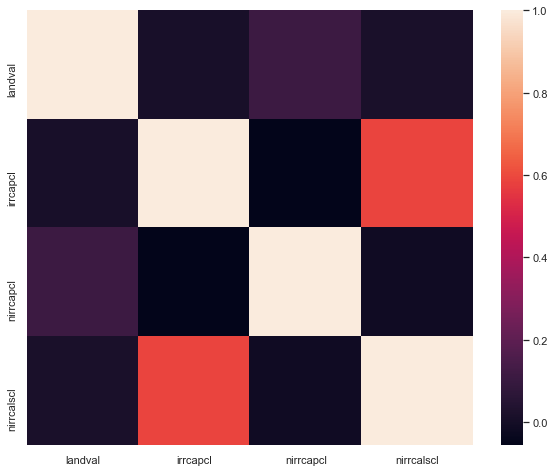

In [1780]:

print(full_set[['landval', 'irrcapcl', 'nirrcapcl', 'nirrcalscl']].corr())

f, ax = plt.subplots(figsize=(10, 8))
corr = full_set[['landval', 'irrcapcl', 'nirrcapcl', 'nirrcalscl']].corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

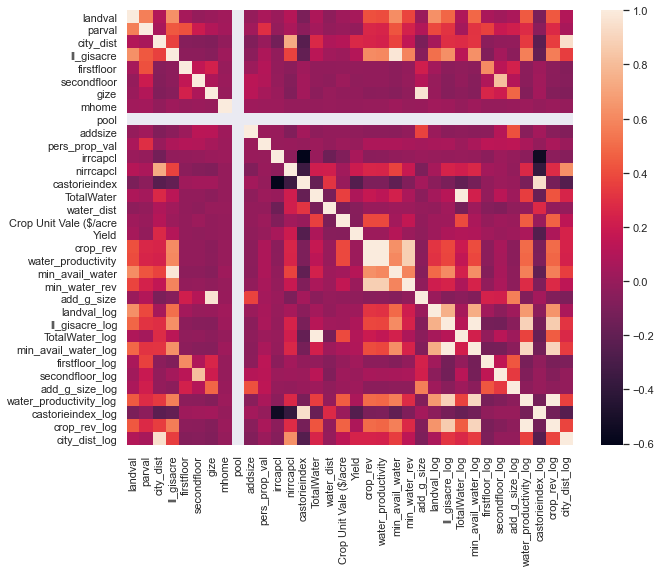

In [1747]:
f, ax = plt.subplots(figsize=(10, 8))
corr = full_set.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [1781]:
full_set.corr()

,landval,parval,city_dist,ll_gisacre,firstfloor,secondfloor,gize,mhome,pool,addsize,...,ll_gisacre_log,TotalWater_log,min_avail_water_log,firstfloor_log,secondfloor_log,add_g_size_log,water_productivity_log,castorieindex_log,crop_rev_log,city_dist_log
landval,1.000000,0.570543,0.102479,0.636023,0.055569,-0.004404,0.013369,0.036967,NaN,-0.005330,...,0.485586,0.086238,0.485878,0.067835,0.037105,0.071645,0.444707,-0.103187,0.435868,0.101575
parval,0.570543,1.000000,0.061650,0.441504,0.413511,0.202249,0.098500,0.044021,NaN,0.034596,...,0.312291,0.051119,0.312007,0.365062,0.189012,0.219457,0.280752,-0.038999,0.274866,0.062611
city_dist,0.102479,0.061650,1.000000,0.363025,-0.061541,-0.070404,-0.084888,-0.017114,NaN,-0.081862,...,0.292992,0.282204,0.318192,-0.044961,-0.016390,-0.014369,0.339533,-0.225348,0.352701,0.945104
ll_gisacre,0.636023,0.441504,0.363025,1.000000,-0.041015,-0.041044,-0.058248,0.023511,NaN,-0.042596,...,0.629641,0.132009,0.632214,-0.079280,0.049297,-0.039010,0.570316,-0.194968,0.560952,0.348183
firstfloor,0.055569,0.413511,-0.061541,-0.041015,1.000000,0.157698,0.230662,-0.003529,NaN,0.016145,...,-0.035464,-0.023326,-0.037336,0.613949,0.128572,0.232840,-0.039812,0.026635,-0.040457,-0.069781
secondfloor,-0.004404,0.202249,-0.070404,-0.041044,0.157698,1.000000,0.083014,0.012423,NaN,0.128781,...,-0.059035,-0.017601,-0.059845,0.084228,0.817278,0.105878,-0.045504,0.038561,-0.045407,-0.065317
gize,0.013369,0.098500,-0.084888,-0.058248,0.230662,0.083014,1.000000,-0.001319,NaN,0.122886,...,-0.063312,-0.039134,-0.066383,0.257445,0.203711,0.481820,-0.067150,0.042430,-0.068219,-0.079076
mhome,0.036967,0.044021,-0.017114,0.023511,-0.003529,0.012423,-0.001319,1.000000,NaN,0.023035,...,0.023393,-0.006144,0.022288,-0.006253,-0.004712,0.006554,0.016011,-0.005493,0.014841,-0.009514
pool,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
addsize,-0.005330,0.034596,-0.081862,-0.042596,0.016145,0.128781,0.122886,0.023035,NaN,1.000000,...,-0.041714,-0.032934,-0.044514,-0.035207,0.115182,0.412838,-0.047884,0.042132,-0.049109,-0.073637


There are a few interesting things to note here, our parcel acreage had high correlation with land value, crop revenue, and minimum available water. Both minimum available water and crop revenue  used parcel acreage in their construction. So we decided to leave parcel acreage out of our model as it would be over represented. We also captured parcel acreage in our soil_area_index variable below (taken from the Buck paper that inspired this project. 

Many of our infered water variables are also highly correlated as we use total water as the base water metric in their engineering. 

We also made some final omissions and adjustments (see below) to our dataset. Namely narrowing the scope of the parcels by land value, presence of a secondfloor or personal property value (as an indicator of residential use).


In [1782]:
##need to move these filters into the variable eda for them

modeling_set = full_set[(full_set["secondfloor"] < 1) & 
         (full_set["mhome"] < 1)  & 
         (full_set["pers_prop_val"] < 1) & 
         (full_set["landval"] < 1000000) & 
         (full_set["landval"] > 10000)].copy()

#replace infinity and negative infinity with 0
modeling_set.replace([np.inf, -np.inf], 0, inplace=True)
modeling_set.dropna(inplace=True)

#soil quality applied across acreage
modeling_set['soil_area_index'] = full_set['castorieindex']*full_set['ll_gisacre']

len(modeling_set)

#filter out parvals between 

10005

In [ ]:
Our final hedonic regression formula :
    
    

In [1989]:
y_ln = modeling_set['landval_log']

X_log = modeling_set[['min_avail_water_log', 'water_dist', 'farmlndcl', 'nirrcapcl', 'crop_rev', 'city_dist_log', 'soil_area_index']]

print(X_log.shape)


(10005, 7)


In [1850]:
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y_ln, test_size=0.2, random_state=1)



In [1851]:
scaler2 = StandardScaler()
X_log_train = pd.DataFrame(scaler2.fit_transform(X_log_train), columns=X_log_train.columns)
X_log_test = pd.DataFrame(scaler2.transform(X_log_test), columns=X_log_test.columns)

In [2010]:
ols = LinearRegression()
ols.fit(X_log_train, y_log_train)

print("\n================ SUMMARY TABLE   =================")
print("R-squared:", ols.score(X_log_train, y_log_train))
print("Intercept:", ols.intercept_)
x_loglabels = X_log.columns
print("Coefficients:\n") 
for i in range(len(x_loglabels)): 

    print(x_loglabels[i] + '\t\t' + str(ols.coef_[i]))




================ SUMMARY TABLE   =================
R-squared: 0.5413799367260458
Intercept: 11.614387342088394
Coefficients:

min_avail_water_log		0.6098898683637333
water_dist		-0.04176623374547142
farmlndcl		-0.05865792836534306
nirrcapcl		-0.051730849667488886
crop_rev		0.04182924832451536
city_dist_log		-0.18888833642382025
soil_area_index		0.20859341972957834


In [1853]:

# Collect the coefficients

df_ols_coef = pd.DataFrame(ols.coef_, index=X_log_train.columns, columns=['Coefficients'])
df_ols_coef['Coef_abs'] = df_ols_coef.Coefficients.abs()

In [1854]:
predictions_train_log = ols.predict(X_log_train)
predictions_test_log = ols.predict(X_log_test)

In [1855]:
cv_scores = cross_val_score(ols, X_log_train, y_log_train, cv=5)
print('Training Score:', ols.score(X_log_train, y_log_train))
print('Cross validation scores:', cv_scores)
print('Mean cross validation score:', cv_scores.mean())
print('Test Score:', ols.score(X_log_test, y_log_test))

Training Score: 0.5413799367260458
Cross validation scores: [0.5496813  0.52421542 0.52635419 0.56468401 0.53509632]
Mean cross validation score: 0.5400062497463397
Test Score: 0.5367836236311627


## Model Evaluation



For evaluation we computed mean squared error, root mean squared error, and compared OLS, Ridge, and Lasso methods with consistent train and test results across. 

We also produced a qq plot of our residuals to check their distribution and tested the skew and kurtosis.  

In [1859]:
print('Mean Squared Error:', metrics.mean_squared_error(y_log_test, predictions_test_log)) 
print('Root Mean Squared Error:', (metrics.mean_squared_error(y_log_test, predictions_test_log))**0.5)

Mean Squared Error: 0.4441727450113738
Root Mean Squared Error: 0.6664628609392829


In [1860]:
ols_residuals = (y_log_train - predictions_train_log)
ols_residuals.describe()

count    8.004000e+03
mean     1.397294e-15
std      6.513711e-01
min     -2.680490e+00
25%     -4.128116e-01
50%     -1.834675e-02
75%      3.658364e-01
max      3.562940e+00
Name: landval_log, dtype: float64

In [1861]:
print("Skew:", ols_residuals.skew())
print("Kurtosis:", ols_residuals.kurtosis())
stat, p = shapiro(ols_residuals)
print('Shapiro-Wilk test on normality=%.3f, p=%.3f' % (stat, p))

Skew: 0.2995226519984114
Kurtosis: 0.8209688227543035
Shapiro-Wilk test on normality=0.991, p=0.000


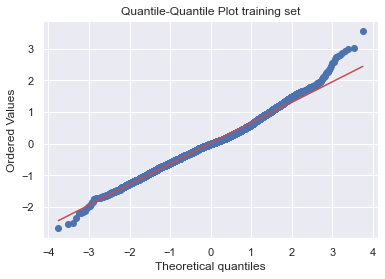

In [1862]:
stats.probplot(ols_residuals, dist="norm", plot=plt)
plt.title("Quantile-Quantile Plot training set");

#### Cross Validations

In [1857]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores_shuffled = cross_val_score(ols, X_log_train, y_log_train, cv=kf)

print('Shuffled cross validation score:', cv_scores_shuffled)
print('Mean shuffled cross validation score:', cv_scores_shuffled.mean())

Shuffled cross validation score: [0.55174994 0.55489354 0.53543586 0.51768756 0.53840704]
Mean shuffled cross validation score: 0.5396347872080351


In [1868]:
# Ridge Cross-Validation
ridge_mod = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
ridge_mod.fit(X_log_train, y_log_train)

print('Best Ridge alpha:', ridge_mod.alpha_)
print('Training score:', ridge_mod.score(X_log_train, y_log_train))
print("Test Score:", ridge_mod.score(X_log_test, y_log_test))

Best Ridge alpha: 2.782559402207126
Training score: 0.5413798500336098
Test Score: 0.5367821957436656


In [1870]:
df_ridge_coef = pd.DataFrame(ridge_mod.coef_, index=X_log_train.columns,
                       columns=['Coefficients'])
df_ridge_coef['Coef_abs'] = df_ridge_coef.Coefficients.abs()

In [1986]:
ridge_mod = Ridge(alpha=2.78)

print('Ridge')
scores = cross_val_score(ridge_mod, X_log_train, y_log_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

ridge_mod.fit(X_log_train, y_log_train)
print("Training Score:", ridge_mod.score(X_log_train, y_log_train))
print("Test Score:", ridge_mod.score(X_log_test, y_log_test))

Ridge
Cross-validated training scores: [0.54969337 0.52422661 0.5263538  0.56466433 0.53509476]
Mean cross-validated training score: 0.5400065748135023
Training Score: 0.541379850192908
Test Score: 0.5367821971368725


In [1873]:
lasso_mod = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
lasso_mod.fit(X_log_train, y_log_train)

print('Best Lasso alpha:', lasso_mod.alpha_)
print('Training score:', lasso_mod.score(X_log_train, y_log_train))
print("Test Score:", lasso_mod.score(X_log_test, y_log_test))

Best Lasso alpha: 0.0001
Training score: 0.5413798589190092
Test Score: 0.5367858630341427


In [1874]:
df_lasso_coef = pd.DataFrame(lasso_mod.coef_, index=X_log_train.columns,
                       columns=['Coefficients'])
df_lasso_coef['Coef_abs'] = df_lasso_coef.Coefficients.abs()

In [1982]:
coef = pd.concat([df_ols_coef['Coefficients'], df_ridge_coef['Coefficients'], df_lasso_coef['Coefficients']])
coef = pd.DataFrame(coef)
coef.reset_index(level=0, inplace=True)
coef.columns = ['variable', 'coefficient']


In [1983]:
coef.loc[0:6]["model"] = "ols"
coef.loc[7:13]["model"] = "ridge"
coef.loc[14:20]["model"] = "lasso"
coef

,variable,coefficient
0,min_avail_water_log,0.609890
1,water_dist,-0.041766
2,farmlndcl,-0.058658
3,nirrcapcl,-0.051731
4,crop_rev,0.041829
5,city_dist_log,-0.188888
6,soil_area_index,0.208593
7,min_avail_water_log,0.609556
8,water_dist,-0.041741
9,farmlndcl,-0.058646


### Interpreting water value as a portion of land value 

To infer the value of water constituent to the value of land,  we applied the water variable coefficients from our hedonic model to the land value to get the monetary value of water as a portion of the land value. 

While our minimum available water coefficient was already in log form, we had to scale our water distance and irrigation coefficients and sum all three to compute the percentage of a 1$ increase in land value that our water coefficients comprised. Leaving us with a (rather dubious) 51% of land the land value being water access.

While it makes sense that water distance and irrigation type would have negative coefficients while minimum availablable water would have positive ones, when combined with our r-squared values of ~0.54 our model is missing something pretty significant in terms of contributing variable(s) to land value

In [1878]:
#water dist and irrigation type are not log tranformed 
 
import math
water_dist = math.exp(-0.04176623)
irrigation = math.exp(-0.05173085)
(water_dist -1) + (irrigation -1) + 0.60988987

0.5185682448594812

In [1885]:

output = full_set[['parcelnumb', 'county', 'szip', 'FinalCrop', 'Yield', 'yield_units', 'crop_rev', 'landval']]


In [1886]:
#using log tranformed coefficients
output['water_val'] = output['landval']* 0.5185682448594812
output.head()

,parcelnumb,county,szip,FinalCrop,Yield,yield_units,crop_rev,landval,water_val
0,37002003,fresno,93654-9320,GRAPES,13.23,tons/acre,10182.294,207423.0,107562.981053
1,35302073,fresno,93625-9728,GRAPES,13.23,tons/acre,21557.280,119474.0,61955.422486
2,04233003,fresno,93725-9118,GRAPES,13.23,tons/acre,94527.246,359218.0,186279.047782
3,04234005,fresno,93609-9726,GRAPES,13.23,tons/acre,8067.606,31632.0,16403.350721
4,04234009,fresno,93609-9764,GRAPES,13.23,tons/acre,23186.106,147651.0,76567.119922


In [1887]:
output.to_csv('fresno_watervalue_derived_4_19.csv', columns=('parcelnumb', 'county', 'szip', 'landval', 'water_val', 'FinalCrop', 'Yield', 'yield_units', 'crop_rev'))

